In [2]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score
from sklearn import metrics

warnings.filterwarnings('ignore')

data = pd.read_csv("..\\CO2_Emissions_Canada.csv", delimiter=',')
data["Vehicle Class"] = data["Vehicle Class"].astype("category")
data["Model"] = data["Model"].astype("category")
data["Make"] = data["Make"].astype("category")
data["Transmission"] = data["Transmission"].astype("category")
data.tail(5)

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
7380,VOLVO,XC40 T5 AWD,SUV - SMALL,2.0,4,AS8,Z,10.7,7.7,9.4,30,219
7381,VOLVO,XC60 T5 AWD,SUV - SMALL,2.0,4,AS8,Z,11.2,8.3,9.9,29,232
7382,VOLVO,XC60 T6 AWD,SUV - SMALL,2.0,4,AS8,Z,11.7,8.6,10.3,27,240
7383,VOLVO,XC90 T5 AWD,SUV - STANDARD,2.0,4,AS8,Z,11.2,8.3,9.9,29,232
7384,VOLVO,XC90 T6 AWD,SUV - STANDARD,2.0,4,AS8,Z,12.2,8.7,10.7,26,248


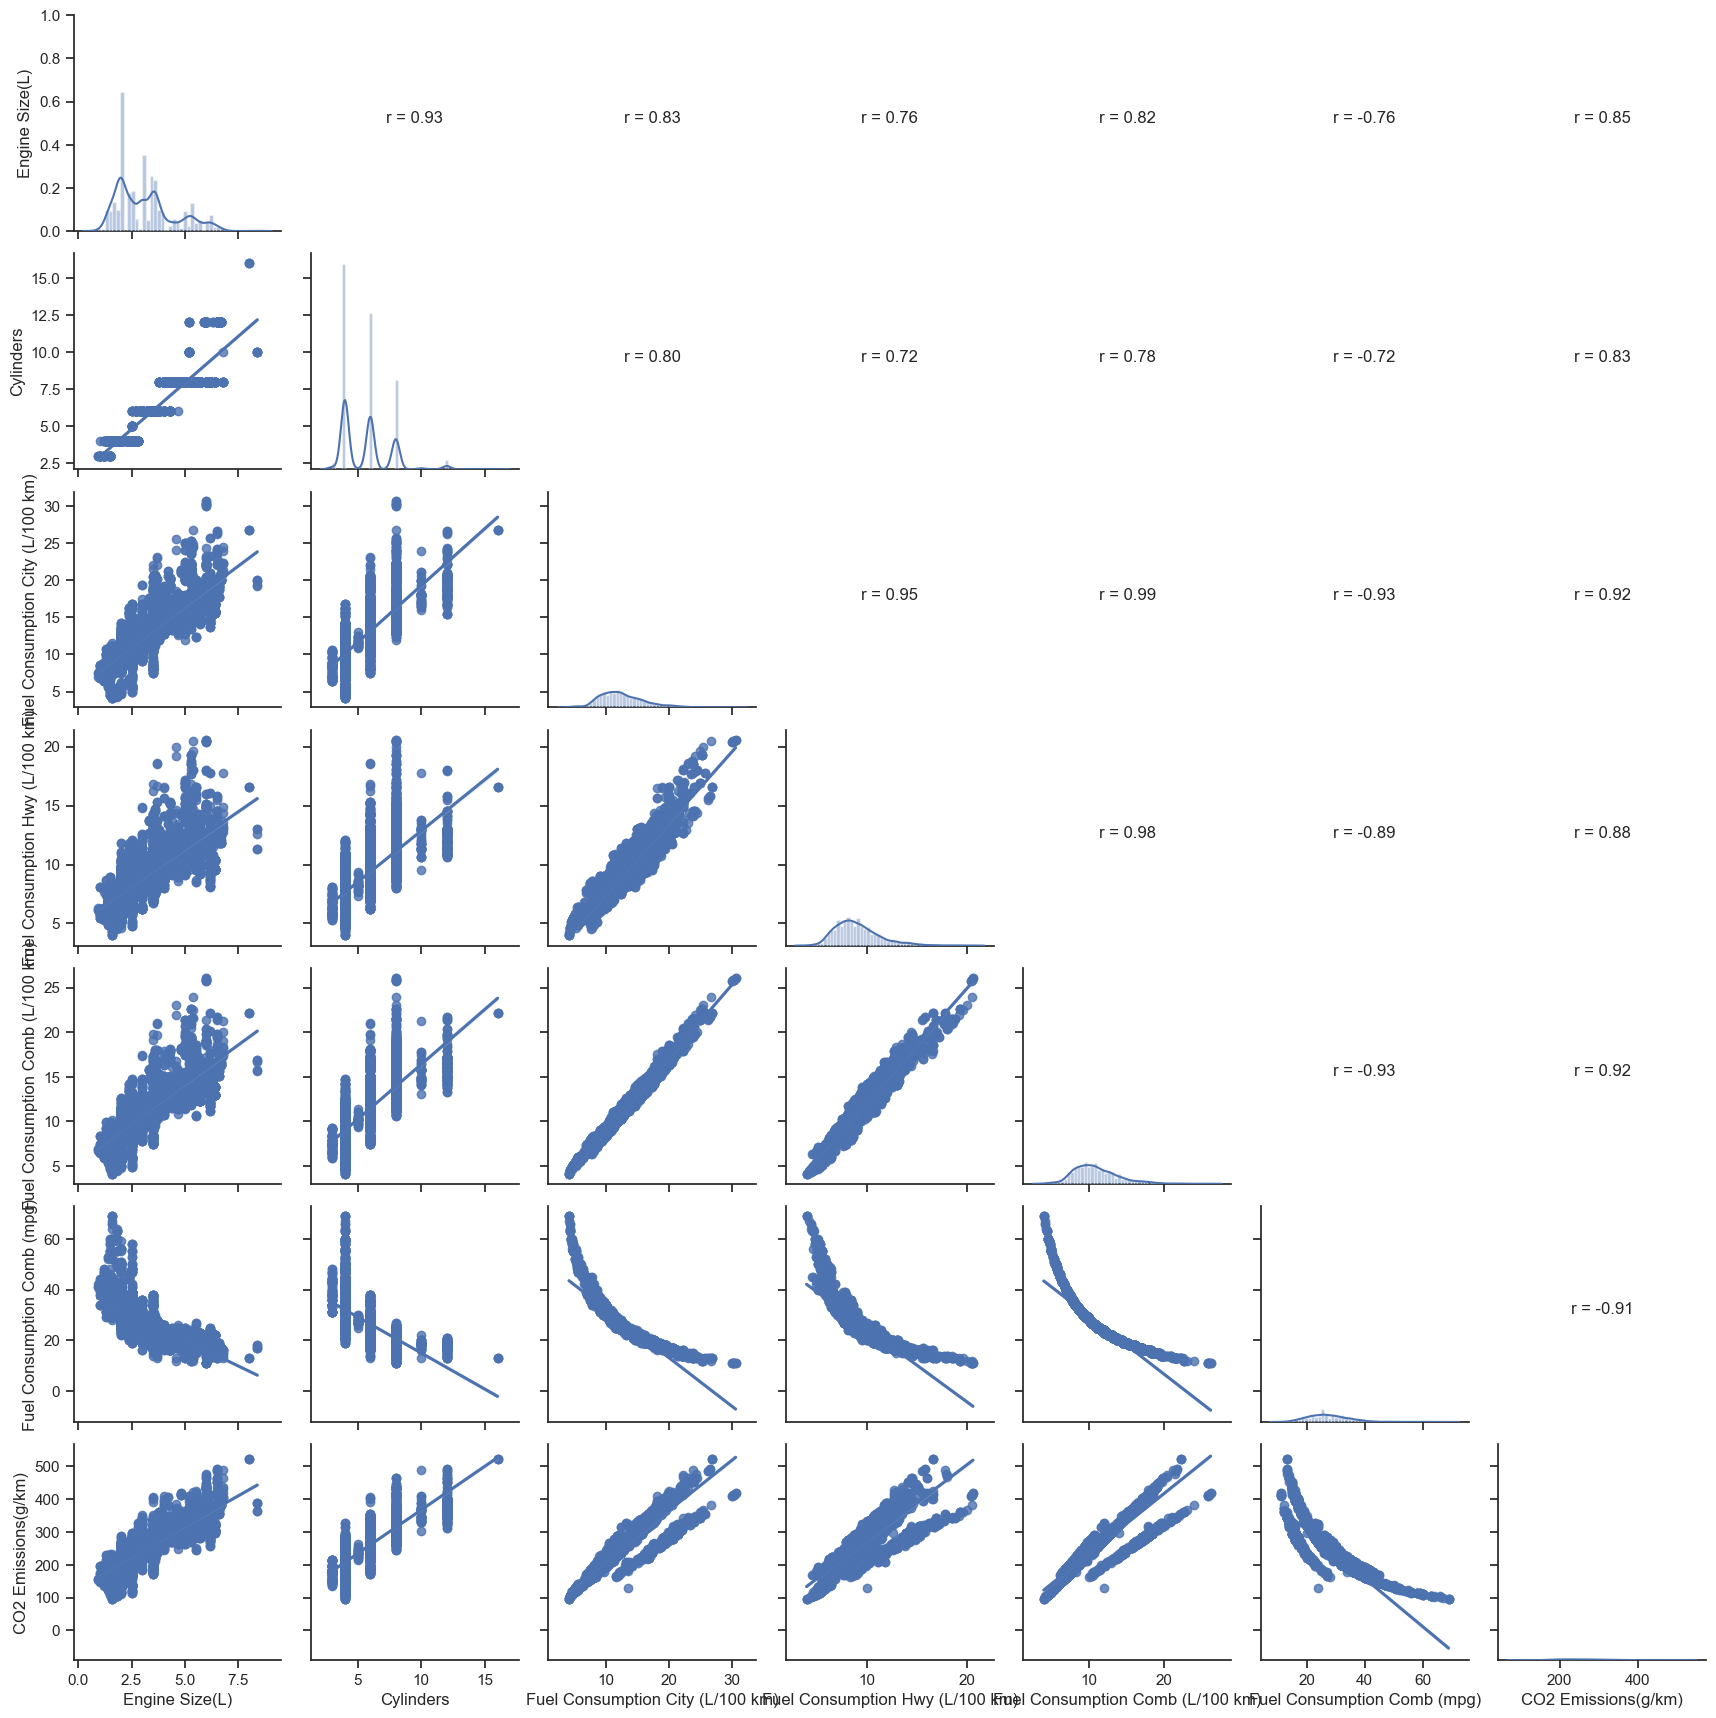

In [3]:
def reg_coef(x,y,label=None,color=None,**kwargs):
    ax = plt.gca()
    r, _ = pearsonr(x,y)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center')
    ax.set_axis_off()

sns.set_theme(style="ticks")
g = sns.PairGrid(data, palette=["b", "r", "g", "y", "orange"])
g.map_diag(sns.distplot)
g.map_lower(sns.regplot)
g.map_upper(reg_coef)
plt.show()

In [4]:
#data transformation
le = preprocessing.LabelEncoder()
data["Make"] = le.fit_transform(data["Make"])
data["Model"] = le.fit_transform(data["Model"])
data["Vehicle Class"] = le.fit_transform(data["Vehicle Class"])
data["Transmission"] = le.fit_transform(data["Transmission"])
data["Fuel Type"] = le.fit_transform(data["Fuel Type"])

#Transform CO2Emissions into classification variable by splitting them into HIGH(0) and LOW(1)
co2_mean = round(data["CO2 Emissions(g/km)"].mean(), 0)

def categorizeCO2(x):
    if x >= co2_mean:
        return 0
    else:
        return 1

data["CO2 Emissions(g/km)"] = data["CO2 Emissions(g/km)"].apply(categorizeCO2)

In [5]:
#Setting random state for reproducibility
random_state=12345

feature_cols = ['Make', 'Model', 'Vehicle Class', 'Engine Size(L)', 'Cylinders', 'Transmission',
                'Fuel Type', "Fuel Consumption City (L/100 km)", "Fuel Consumption Hwy (L/100 km)",
                "Fuel Consumption Comb (L/100 km)"]
X = data[feature_cols]
y = data["CO2 Emissions(g/km)"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)

lda = LinearDiscriminantAnalysis().fit(X_train, y_train)
lda_pred = lda.predict(X_test)
lda_prob = lda.predict_proba(X_test)[:,1]

print ("Accuracy Score of the model: " + str(round(lda.score(X_test, y_test) * 100, 2)) + "%")

Accuracy Score of the model: 91.43%


Text(0, 0.5, 'Predictions')

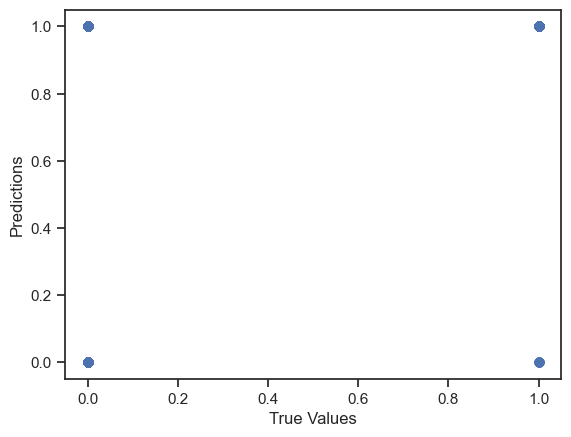

In [6]:
plt.scatter(y_test, lda_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")

In [7]:
lda_cfm = confusion_matrix(y_test, lda_pred, labels=lda.classes_)
lda_acc = round(accuracy_score(y_test, lda_pred), 4)

lda_cfm

array([[ 981,  156],
       [  53, 1248]], dtype=int64)

In [8]:
print("Accuracy score is: " + str(round(lda_acc * 100, 2)) + "%")

Accuracy score is: 91.43%


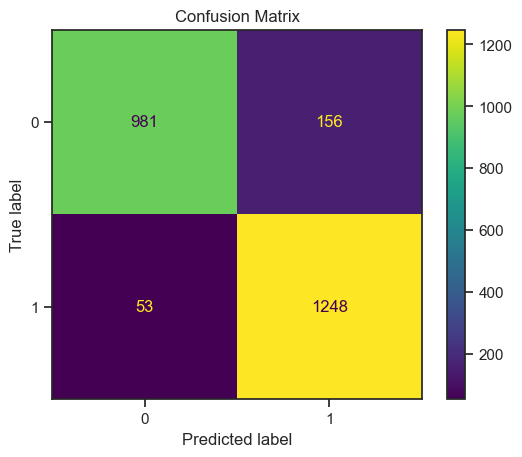

In [9]:
disp = ConfusionMatrixDisplay(confusion_matrix=lda_cfm, display_labels=lda.classes_)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

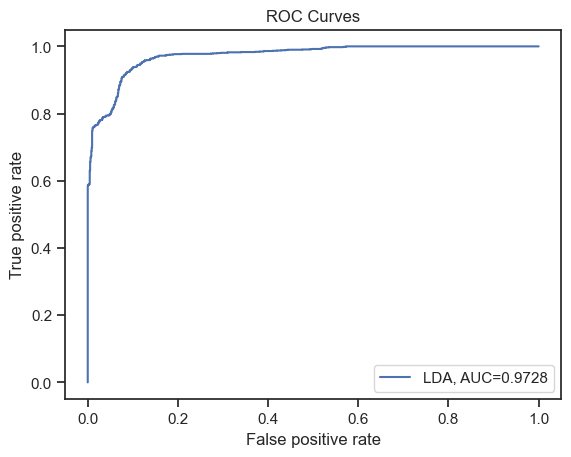

In [10]:
plt.figure(0).clf()

fpr, tpr, _ = metrics.roc_curve(y_test, lda_prob)
lda_auc = round(metrics.roc_auc_score(y_test, lda_prob), 4)
plt.plot(fpr, tpr, label="LDA, AUC="+str(lda_auc))

plt.title("ROC Curves")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend()

In [11]:
print(classification_report(y_test, lda_pred))

              precision    recall  f1-score   support

           0       0.95      0.86      0.90      1137
           1       0.89      0.96      0.92      1301

    accuracy                           0.91      2438
   macro avg       0.92      0.91      0.91      2438
weighted avg       0.92      0.91      0.91      2438

